In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from optuna.samplers import TPESampler

2023-11-06 10:44:22.497496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martevingsnes/Machine-learning-066/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = os.getcwd()

In [3]:
# Directory paths for each group of data
train_dirpath_A = os.path.join(root, "data", "A")
train_dirpath_B = os.path.join(root, "data", "B")
train_dirpath_C = os.path.join(root, "data", "C")

# pv_measurement for all training and validation rows
a_targets = pd.read_parquet(os.path.join(train_dirpath_A, 'train_targets.parquet'))
b_targets = pd.read_parquet(os.path.join(train_dirpath_B, 'train_targets.parquet'))
c_targets = pd.read_parquet(os.path.join(train_dirpath_C, 'train_targets.parquet'))

# training data
X_train_observed_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_observed.parquet'))
X_train_observed_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_observed.parquet'))
X_train_observed_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_observed.parquet'))

# validation data
X_train_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_estimated.parquet'))
X_train_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_estimated.parquet'))
X_train_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_estimated.parquet'))

# test data
X_test_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_test_estimated.parquet'))
X_test_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_test_estimated.parquet'))
X_test_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_test_estimated.parquet'))

### Autogluon

In [4]:
X_train_estimated_a

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2022-10-27 07:00:18,2022-10-28 22:00:00,8.4,1.233,1425.099976,0.0,0.0,1211.699951,1.0,281.399994,...,340.799011,-38.466999,0.0,284.700012,100.000000,29429.699219,0.8,-0.4,0.7,-0.0
1,2022-10-27 07:00:18,2022-10-28 22:15:00,8.4,1.233,2085.899902,0.0,0.0,1560.500000,1.0,281.299988,...,345.451996,-38.955002,0.0,284.700012,100.000000,23604.099609,0.7,-0.4,0.7,-0.0
2,2022-10-27 07:00:18,2022-10-28 22:30:00,8.3,1.233,2746.600098,0.0,0.0,1909.400024,1.0,281.200012,...,350.153015,-39.310001,0.0,284.700012,100.000000,17799.800781,0.7,-0.3,0.6,-0.0
3,2022-10-27 07:00:18,2022-10-28 22:45:00,8.3,1.233,3407.399902,0.0,0.0,2258.199951,1.0,281.200012,...,354.886993,-39.528999,0.0,284.600006,100.000000,12016.500000,0.6,-0.2,0.6,-0.0
4,2022-10-27 07:00:18,2022-10-28 23:00:00,8.2,1.233,4068.199951,0.0,0.0,2607.000000,1.0,281.100006,...,359.638000,-39.609001,0.0,284.600006,100.000000,6254.399902,0.6,-0.1,0.6,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571,2023-04-29 07:00:05,2023-04-30 22:45:00,4.5,1.281,1173.900024,0.0,0.0,536.500000,0.0,272.299988,...,352.920013,-11.731000,0.1,274.200012,99.900002,11629.299805,3.9,2.9,2.5,-0.0
17572,2023-04-29 07:00:05,2023-04-30 23:00:00,4.5,1.281,1054.199951,0.0,0.0,542.400024,0.0,272.200012,...,356.634003,-11.884000,0.1,274.200012,100.000000,9923.200195,3.7,2.8,2.4,-0.0
17573,2023-04-29 07:00:05,2023-04-30 23:15:00,4.5,1.281,1435.800049,0.0,0.0,531.799988,0.0,272.299988,...,0.352000,-11.928000,0.1,274.200012,99.900002,11230.799805,3.7,2.7,2.5,-0.0
17574,2023-04-29 07:00:05,2023-04-30 23:30:00,4.5,1.281,1817.400024,0.0,0.0,521.200012,0.0,272.299988,...,4.070000,-11.864000,0.1,274.200012,99.599998,12526.099609,3.8,2.7,2.6,-0.0


In [5]:
X_train_observed_a

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-06-02 22:00:00,7.7,1.230,1744.900024,0.0,0.0,1744.900024,0.0,280.299988,0.0,...,342.834015,-3.202000,0.0,285.899994,100.0,39640.101562,3.7,-3.6,-0.8,-0.0
1,2019-06-02 22:15:00,7.7,1.229,1734.000000,0.0,0.0,1734.000000,0.0,280.299988,0.0,...,346.294006,-3.650000,0.0,286.100006,100.0,40123.898438,3.6,-3.6,-0.6,-0.0
2,2019-06-02 22:30:00,7.7,1.228,1723.500000,0.0,0.0,1723.500000,0.0,280.299988,0.0,...,349.768005,-3.998000,0.0,286.299988,100.0,40628.300781,3.6,-3.6,-0.4,-0.0
3,2019-06-02 22:45:00,7.7,1.226,1713.400024,0.0,0.0,1713.400024,0.0,280.299988,0.0,...,353.251007,-4.247000,0.0,286.600006,100.0,41153.601562,3.5,-3.5,-0.2,-0.0
4,2019-06-02 23:00:00,7.7,1.225,1703.599976,0.0,0.0,1703.599976,0.0,280.299988,0.0,...,356.742004,-4.393000,0.0,286.799988,100.0,41699.898438,3.5,-3.5,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118664,2022-10-21 00:00:00,5.0,1.292,NaN,0.0,0.0,NaN,0.0,273.700012,0.0,...,16.612000,-36.306000,0.0,276.899994,2.8,25791.000000,1.3,-0.4,1.2,-0.0
118665,2022-10-21 00:15:00,5.0,1.292,NaN,0.0,0.0,NaN,0.0,273.700012,0.0,...,21.132999,-35.762001,0.0,276.799988,2.3,28560.599609,1.4,-0.6,1.2,-0.0
118666,2022-10-21 00:30:00,5.0,1.292,NaN,0.0,0.0,NaN,0.0,273.700012,0.0,...,25.594000,-35.095001,0.0,276.600006,1.7,31317.800781,1.4,-0.8,1.2,-0.0
118667,2022-10-21 00:45:00,5.0,1.292,NaN,0.0,0.0,NaN,0.0,273.600006,0.0,...,29.988001,-34.311001,0.0,276.500000,1.1,34062.601562,1.5,-1.0,1.1,-0.0


In [6]:
X_train_estimated_a['is_predicted'] = 1
X_train_observed_a['is_predicted'] = 0

X_train_estimated_b['is_predicted'] = 1
X_train_observed_b['is_predicted'] = 0

X_train_estimated_c['is_predicted'] = 1
X_train_observed_c['is_predicted'] = 0

X_test_estimated_a['is_predicted'] = 1
X_test_estimated_b['is_predicted'] = 1
X_test_estimated_c['is_predicted'] = 1

X_test_estimated_a.drop(columns=['date_calc'], inplace=True) 
X_test_estimated_b.drop(columns=['date_calc'], inplace=True) 
X_test_estimated_c.drop(columns=['date_calc'], inplace=True) 

In [7]:
def move_rows(training, validation):
    num_rows_to_remove = int(0.5 * len(validation))

    # Remove the first num_rows_to_remove rows from X_train_estimated_a and add them to X_train_observed_a
    removed_data = validation.iloc[:num_rows_to_remove]
    validation = validation.iloc[num_rows_to_remove:]
    training = pd.concat([training, removed_data], ignore_index=True)

    validation.drop(columns=['date_calc'], inplace=True)  
    training.drop(columns=['date_calc'], inplace=True)  


    return training, validation

In [8]:
X_train_observed_a, X_train_estimated_a = move_rows(X_train_observed_a, X_train_estimated_a)
X_train_observed_b, X_train_estimated_b = move_rows(X_train_observed_b, X_train_estimated_b)
X_train_observed_c, X_train_estimated_c = move_rows(X_train_observed_c, X_train_estimated_c)

/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_48994/1787251946.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.drop(columns=['date_calc'], inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_48994/1787251946.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.drop(columns=['date_calc'], inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_48994/1787251946.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [9]:
def aggregate_data(df):
    df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')

    df.set_index('hourly_timestamp', inplace=True)

    aggregations = {col: 'median' for col in df.columns if col != 'date_forecast'}
    aggregations['date_forecast'] = 'first'

    df = df.groupby('hourly_timestamp').agg(aggregations).reset_index()

    df.drop(columns=['hourly_timestamp'], inplace=True)
    df['date_forecast'] = df['date_forecast'].dt.floor('H')
    
    return df

In [10]:
def process(data, targets, visualize=False):
    aggregated_data = aggregate_data(data.copy())
    
    merged_data = aggregated_data.merge(targets[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
    merged_data.dropna(subset=['pv_measurement'], inplace=True)

    #if visualize:
        #visualize_pv_measurement(merged_data)

    y = merged_data["pv_measurement"]
    X = merged_data.drop(columns=['pv_measurement', 'date_forecast', 'time'])
    return X, y

In [11]:
X_train_A, y_train_A = process(X_train_observed_a, a_targets, visualize=True)
X_val_A, y_val_A = process(X_train_estimated_a, a_targets)

X_test_A = aggregate_data(X_test_estimated_a.copy())

X_train_B, y_train_B = process(X_train_observed_b, b_targets, visualize=True)
X_val_B, y_val_B = process(X_train_estimated_b, b_targets)

X_test_B = aggregate_data(X_test_estimated_b.copy())

X_train_C, y_train_C = process(X_train_observed_c, c_targets, visualize=True)
X_val_C, y_val_C = process(X_train_estimated_c, c_targets)

X_test_C = aggregate_data(X_test_estimated_c.copy())

In [12]:
# Clean feature names 
def clean_feature_names(df_list):
    for df in df_list:
        df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Apply the cleaning function to your dataframes
lista = [X_train_A, X_val_A, X_test_A, X_train_B, X_val_B, X_test_B, X_train_C, X_val_C, X_test_C]
clean_feature_names(lista)

In [13]:
X_test_A.drop(columns=['date_forecast'], inplace=True) 
X_test_B.drop(columns=['date_forecast'], inplace=True) 
X_test_C.drop(columns=['date_forecast'], inplace=True) 

In [14]:
from autogluon.tabular import TabularPredictor

def train_auto_gluon(X_train, y_train, X_val, y_val):
    # Create and train the AutoGluon model with a progress bar
    train = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    validation = pd.concat([X_val, y_val.reset_index(drop=True)], axis=1)

    predictor = TabularPredictor(label='pv_measurement', verbosity=2)
    predictor.fit(train_data=train, tuning_data=validation)

    return predictor

In [15]:
predictor_A = train_auto_gluon(X_train_A, y_train_A, X_val_A, y_val_A)
predictor_B = train_auto_gluon(X_train_B, y_train_B, X_val_B, y_val_B)
predictor_C = train_auto_gluon(X_train_C, y_train_C, X_val_C, y_val_C)

# Making predictions
y_pred_A = predictor_A.predict(X_test_A)
y_pred_B = predictor_B.predict(X_test_B)
y_pred_C = predictor_C.predict(X_test_C)

No path specified. Models will be saved in: "AutogluonModels/ag-20231106_094428/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231106_094428/"
AutoGluon Version:  0.8.2
Python Version:     3.9.2
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:42:42 PDT 2023; root:xnu-10002.1.13~1/RELEASE_X86_64
Disk Space Avail:   828.42 GB / 1000.24 GB (82.8%)
Train Data Rows:    31864
Train Data Columns: 46
Tuning Data Rows:    2197
Tuning Data Columns: 46
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 633.81833, 1166.12452)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'mu

Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5991.47 MB
	Train Data (Original)  Memory Usage: 6.95 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 2): ['elevation_m', 'snow_drift_idx']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be pres

: 

In [ ]:
test_data = pd.read_csv(os.path.join(root, 'test.csv'))
location_a_test = test_data[test_data['location'] == "A"]
location_b_test = test_data[test_data['location'] == "B"]
location_c_test = test_data[test_data['location'] == "C"]

# Combine predictions into a single DataFrame
submission_A = pd.DataFrame({'id': location_a_test['id'], 'predicted_values': y_pred_A})
submission_B = pd.DataFrame({'id': location_b_test['id'], 'predicted_values': y_pred_B})
submission_C = pd.DataFrame({'id': location_c_test['id'], 'predicted_values': y_pred_C})

# Combine all location submissions into one DataFrame
final_submission = pd.concat([submission_A, submission_B, submission_C], ignore_index=True)

# Apply the condition to the 'predicted_values' column
final_submission['predicted_values'] = np.where(final_submission['predicted_values'] < 10, 0, final_submission['predicted_values'])

# Save the combined predictions to a single CSV file
final_submission.to_csv('Submissions/submission_stackedLGBM_predictedfeature.csv', index=False)

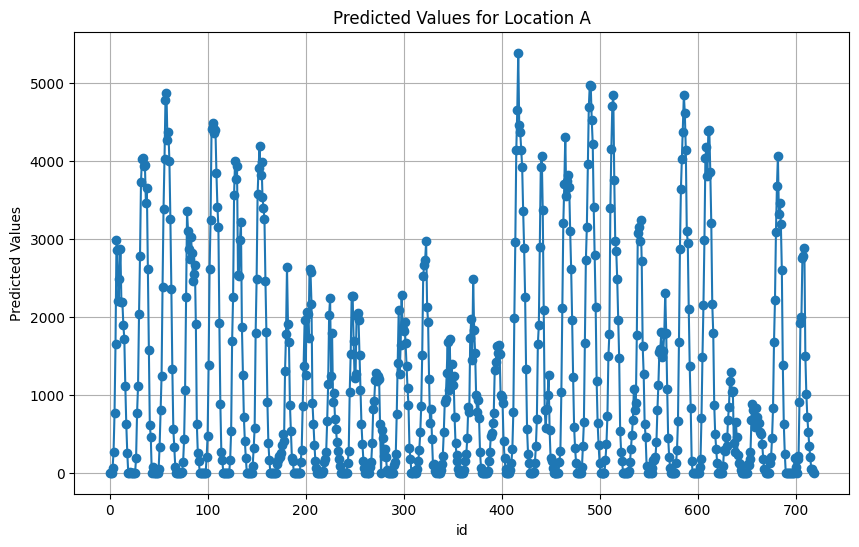

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'submission_A' DataFrame as described
x = submission_A['id']
y = submission_A['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location A')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

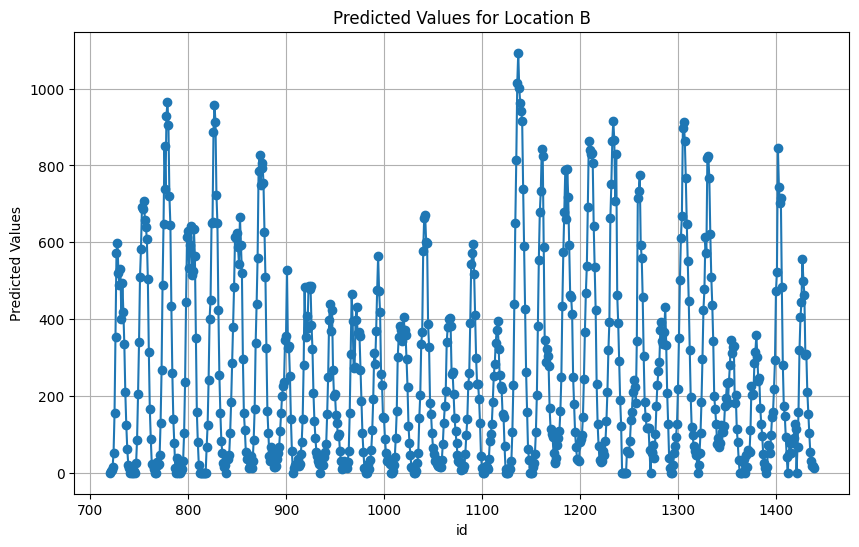

In [ ]:
x = submission_B['id']
y = submission_B['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location B')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

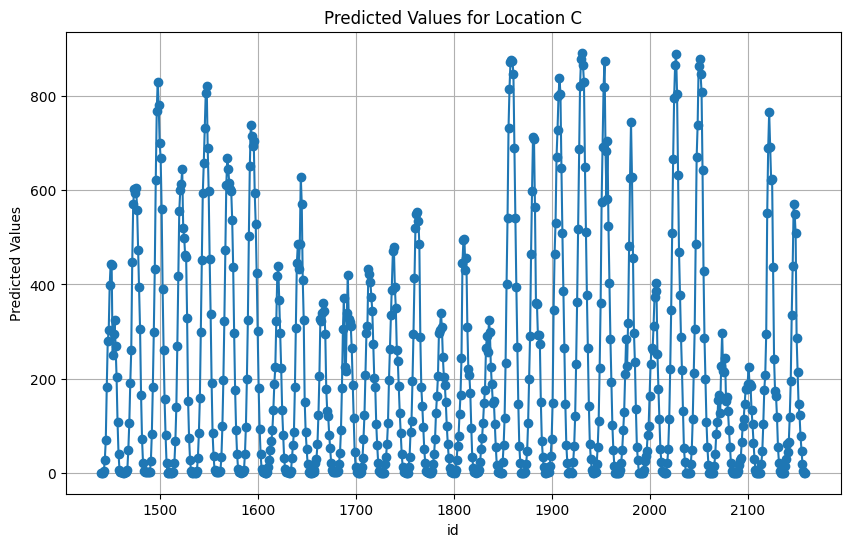

In [ ]:
x = submission_C['id']
y = submission_C['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location C')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()